# Goals of this Notebook

In this notebook we want to explore topics related to performing **Bayesian inference** (in particular **Bayesian parameter estimation**) using a **Gaussian Process** (GP) surrogate.

The specific example is related to the phenomenology of heavy-ion collisions.
It was realized early in the 21st century that the harmonic flows $v_2$, which can be measured by $n$-particle correlations, show sensitivity to the transport properties of a Quark Gluon Plasma(QGP) fluid.
More specifically, the 'elliptic flow' $v_2$ shows sensitivity to the specific shear viscosity $\eta/s$.
Therefore, a common practice in phenomenology is compare hydrodynamic models with a parametrized specific shear viscosity to observables measured in experiments such as the elliptic flow, to try and **infer** the specific shear viscosity of the physical QGP. 

## Bayesian Inference

A statistical methodology designed to handle arbitrarily complicated problems of inference is **Bayesian Inference**. 

Suppose we know some information $D$, for example a set of experimental measurements. 
Now, suppose we want to make an inference about a proposition $\theta$, for example some physical property of system which can not be directly measured. 

Bayes theorem can be written $$p(\theta|D) = \frac{ p(D|\theta) p(\theta) }{ p(D) },$$
where $p(\theta|D)$ is our "posterior" for the proposition $\theta$ given that $D$ is realized, $p(D|\theta)$ is the "likelihood" of observing $D$ given that the proposition $\theta$ is realized, $p(\theta)$ is our "prior" belief about $\theta$ before observing $D$, and $p(D)$ is the "evidence". 

If we are only interested in our proposition $\theta$, than we can use that the evidence is independent of $\theta$ and solve instead the proportionality
$$p(\theta|D) \propto p(D|\theta) p(\theta) .$$ 
This fact will be very useful for Bayesian parameter estimation, as the usual numerical methods to estimate the posterior will exploit it. 

# Inferring the shear viscosity given the Elliptic Flow

We can use Bayes theorem to infer the specific shear viscosity of QGP given the observed data for the elliptic flow.

In this case the specific shear viscosity will be represented by $\theta$, and the observed experimental data for the elliptic flow in a particular centrality bin will be represented by $D$. 

## Defining our physics model

We see that our likelihood function encodes the conditional probability of observing some value of the elliptic flow given a particular value of the specific shear viscosity. 
This requires us to choose some model which we believe is a good approximation of physics. 
In this case, we will assume that the dynamics of the collision can be modeled accurately by viscous hydrodynamics.

For the purposes of this notebook, we will approximate the hydrodynamic output of the elliptic flow $v_2$ given the specific shear viscosity $\eta/s$ using a linear model.

Ordinarily we would use a hydrodynamic simulation (perhaps MUSIC https://github.com/MUSIC-fluid/MUSIC) to model the physics. We will use a linear-model in this notebook because its not computationally demanding, allowing us to focus on concepts on Bayesian inference. However, whenever we discuss our model, we should have in mind a real physics model.

### Statistical Model Error

Let's add to our linear physics model statistical (uncorrelated) error on top of every prediction for the elliptic flow. 
This will be useful both for understanding how any statistical model errors enter our inference problem. 
(For example, in a real hydrodynamics simulation with a finite number of final state particles, there will be a finite statistical error on our calculated elliptic flow.)

### Expressing the model
Let $y$ denote the ouput $v_2$, and $\theta$ the value of the specific shear viscosity $\eta/s$. We can write our physics model by
$$y = m * \theta + b +\epsilon,$$ 
which has a slope $m$, intercept $b$ and statistical error $\epsilon$.

### Let's import some libraries we will be using

In [1]:
import numpy as np #useful for math operations
import matplotlib.pyplot as plt #plotting
import seaborn as sns #pretty plots
sns.set()

from sklearn.gaussian_process import GaussianProcessRegressor as GPR #for using Gaussian Processes
from sklearn.gaussian_process import kernels #same
from sklearn.preprocessing import StandardScaler #useful for scaling data

import emcee #for performing Markov Chain Monte Carlo
import corner #for plotting the posterior

### This function will define our physics (hydrodynamic) model

In [2]:
#Our linear model for hydrodynamic output in some centrality bin, for example 20-30%

#noise level controls statistical scatter in our physics model $\epsilon$
noise = 0.1 #amount of statistical scatter in our training calculations

def lin_hydro_model(eta_over_s, intercept = 0.12, slope = -0.25, noise = noise):
    """This function will play the role of a 
    realistic event-by-event hydrodynamic model. Here it is a linear model 
    with an additional random noise error."""
    
    y = intercept + slope * (eta_over_s) # the mean model prediction
    dy = noise * y * np.random.normal() #the sampled model statistical error
    y += dy #add the model stat. error to the model mean
    y = np.max([0., y]) #suppose our measurement definition is positive definite
    return y, dy

lin_hydro_model = np.vectorize(lin_hydro_model)

## Using a fast Model Emulator for slow physics models 

A real viscous hydrodynamic physics model could take hours to run a single event, and we may need thousands of events to construct a centrality average. Therefore, for computationally demanding models we can employ a fast surrogate (non-parametric interpolation) which can estimate the interpolation uncertainty. 
We use Gaussian processes for this purpose in this notebook. 

Like any interpolation, we need a sampling of points in our parameter space where we know the **physics model output**. 

So, we first run our physics simulation on a sampling of points that **fill our parameter space** and call this sample our **design points**.

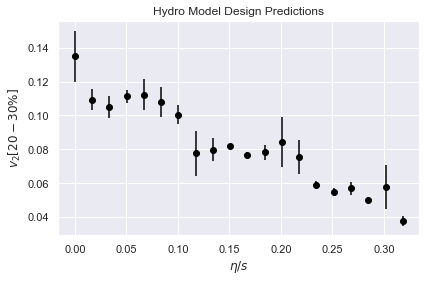

In [3]:
n_design_pts = 20 # this sets the number of design points where we will run our hydro model
eta_over_s_min = 0. # this defines a minimum value for our parameter (eta/s)
eta_over_s_max = 4. / (4. * np.pi) # this defines a maximum value for our parameter (eta/s)

#this chooses our sample to be a regular grid, which is an efficient sampling in one dimension
#it is reshaped into a 2D array so that we can readily use it with scikit-learn
model_X = np.linspace(eta_over_s_min, eta_over_s_max, n_design_pts).reshape(-1,1)

#these are the v_2 outputs of our hydro model, assuming that the model has finite statistical error
model_y, model_dy = lin_hydro_model(model_X)

#lets plot our physics models predictions
plt.errorbar(model_X.flatten(), model_y.flatten(), model_dy.flatten(), fmt='o', c='black')
plt.xlabel(r'$\eta/s$')
plt.ylabel(r'$v_2 [ 20-30\%]$')
plt.title('Hydro Model Design Predictions')
plt.tight_layout(True)
plt.show()

### Exercises:
1. Does it look like a linear model produced these data? Should it?
2. Try playing with the amount of noise (error) in these data.

### Training our Gaussian Process (GP)
We will use a Gaussian process (https://en.wikipedia.org/wiki/Gaussian_process) to interpolate between the design points.

For an intuitive feeling for how they work, play with this widget http://www.tmpl.fi/gp/.
For more details see http://www.gaussianprocess.org/gpml/chapters/RW.pdf.

A Gaussian Process is defined with some choice of a **kernel function**. 
Please see this page for a brief explanation of a few popular kernels : https://www.cs.toronto.edu/~duvenaud/cookbook/.


We tell scikit-learn the GP kernel function to use, and some guidance for the range of the hyperparameters. Then when we call the `fit()` operation, scikit-learn automatically finds the values of hyperparameters that maximize a likelihood function:

$$\log p(y^*|y_{t}, \theta) \propto -\frac{1}{2}y_{t}^{T} \Sigma^{-1}_{y_t} y_{t} - \frac{1}{2} \log |\Sigma_{y_t}|,$$

where $\Sigma_{y_t}$ is the covariance matrix resulting from applying the covariance function to the **training data**. 

Note: The first term rewards a better fit to the training data, while the second term this likelihood function is a complexity penalty to avoid overfitting. 

### Exercises:
1. Explain why the first term in this likelihood function rewards a GP with hyperparameters that fit the data well.
2. Explain why the second term penalizes a GP which is 'overfit'. What does 'overfit' mean?

### Now we will define and train a GP

We will use a combination of a **Squared Exponential Kernel** and a **White Noise Kernel**.

In [4]:
#scikit-learn only accepts 2d arrays as inputs
model_X = model_X.reshape(-1,1)

#this is the 'size' of possible variation of our parameters, in this case eta/s
ptp = max(model_X) - min(model_X)

#This is our Squared Exponential Kernel
rbf_kern = 1. * kernels.RBF(
                      length_scale=ptp,
                      length_scale_bounds=np.outer(ptp, (1e-2, 1e2)),
                      )
#This is a white noise kernel, 
#necessary because our physics model has finite statistical accuracy
white_kern = kernels.WhiteKernel(
                         noise_level=noise,
                         noise_level_bounds=(noise*1e-2, noise*1e1)
                        )

#our kernel is the sum of the Sq. Exponential and White Noise kernels
my_kernel = (rbf_kern + white_kern) 

### Exercises:
1. Why do we need a White Noise Kernel?
2. What does the hyperparameter which controls the 'length scale' in the Squared Exponential kernel control? How does it relate to under/over-fitting?

As with many machine learning toolkits, out-of-the-box performance is often best when we first scale our outputs. The 'Standard Scaler' (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) is convenient for this purpose.

In [5]:
#first scale our observables 
model_y_copy = model_y.copy()
scaler = StandardScaler(copy=True).fit(model_y_copy)
scaled_model_y = scaler.transform(model_y, copy=True) # the scaled model outputs

### Training our GP on the hydro model calculations

In [6]:
#maximizing the GP likelihood proceeds in an iterative process,
#beginning with a random seed. 
#We want to be sure we find a global max., so we restart it several times
nrestarts=10

#define our Gaussian process, and fit it to the hydro model calculations
my_gp = GPR(kernel=my_kernel,
         alpha=0.01, # the nugget, to stabilize matrix inversions
         n_restarts_optimizer=nrestarts, 
         ).fit(model_X, scaled_model_y)

### Defining an 'emulator'
It's useful to define a function which handles both the scaling of our observables as well as the interpolation with the GP. We call this function the **emulator**. 

In [7]:
def emu_predict(eta_over_s):
    """This function handles the scaling and GP interpolation together, 
    returning our prediction in the ordinary observable space
    rather than the scaled observable space
    This map is what we call our 'emulator'. """
    X = eta_over_s.reshape(-1, 1)
    scaled_y, scaled_dy = my_gp.predict(X, return_std=True)
    y = scaler.inverse_transform(scaled_y).reshape(len(eta_over_s))
    dy = scaled_dy * scaler.scale_
    return y, dy

### Let's check how well our emulator fits the hydro physics model

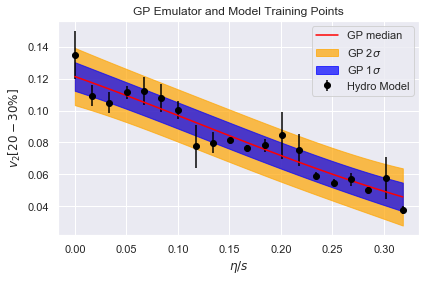

In [8]:
#make a regular grid to plot our Emulator predictions
n_plot_pts = 100
gp_X_plot = np.linspace(eta_over_s_min, eta_over_s_max, n_plot_pts)

#get the GP Emulator's predictions of both the mean and std. deviation
gp_y, gp_dy = emu_predict(gp_X_plot)

plt.plot(gp_X_plot, gp_y, color='red', label='GP median')
plt.fill_between(gp_X_plot, y1 = gp_y - 2.*gp_dy, y2 = gp_y + 2.*gp_dy, 
                 interpolate=True, alpha=0.7, label=r'GP 2$\sigma$', color='orange')
plt.fill_between(gp_X_plot, y1 = gp_y - gp_dy, y2 = gp_y + gp_dy, 
                 interpolate=True, alpha=0.7, label=r'GP 1$\sigma$', color='blue')
plt.errorbar(model_X.flatten(), model_y.flatten(), model_dy.flatten(), fmt='o', c='black', label='Hydro Model')

plt.xlabel(r'$\eta/s$')
plt.ylabel(r'$v_2 [ 20-30\%]$')
plt.title('GP Emulator and Model Training Points')
plt.legend()
plt.tight_layout(True)
plt.savefig('GP.png',dpi=400)
plt.show()

### Exercises:

1. Examine how increasing or decreasing the number of design points can effect the mean and uncertainty of the GP emulator prediction. Does it fit your expectation?

2. Examine how increasing or decreasing the model statistical error can effect the mean and uncertainty of the GP emulator prediction. Does it fit your expectation?

3. Examine how changing the density of design points can effect the mean and uncertainty of the GP emulator prediction(Try a design which has regions which are sparsely populated by design points). Does it fit your expectation?

4. What happens if you remove the white noise kernel `white_kern` from the GP? 

### We expect our emulator to fit the points on which it was trained
...our definition of the GP likelihood function is designed to do just that!

Ultimately, we want to know if our emulator can be trusted for points in parameter space in which it was **not trained**. 

So, let's perform some validations of our GP emulator, using a **novel testing set** of model calculations.

In [9]:
#this defines a new set of points in parameter space where we will run our physics model
n_test_pts = 15
model_X_test = np.random.uniform(eta_over_s_min, eta_over_s_max, n_test_pts).reshape(-1,1)
#get the hydro model predictions for these new points
model_y_test, model_dy_test = lin_hydro_model(model_X_test)

#Now use the emulator trained only on the **original design points** to predict
#outputs on the **new testing set**
gp_y_test, gp_dy_test = emu_predict(model_X_test)

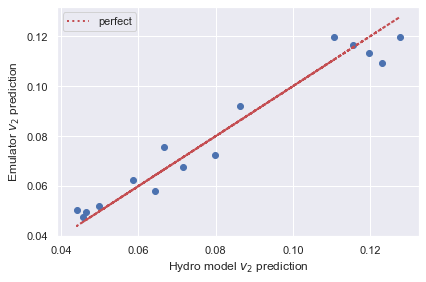

In [10]:
#Plot the emulator prediction vs the hydro model prediction
plt.xlabel(r'Hydro model $v_2$ prediction')
plt.ylabel(r'Emulator $v_2$ prediction')
plt.plot(model_y_test, model_y_test, color='r', label='perfect', ls=':', lw=2)
plt.scatter(model_y_test, gp_y_test)
plt.legend()
plt.tight_layout(True)
plt.show()

### How does the performance look? 
There are stricter tests we can use to check if our surrogate prediction is biased.

If $\hat{y}(\theta)$ is our emulator prediction for the parameters $\theta$, and $y(\theta)$ is our hydro model prediction, we can define the **residual** $\hat{y}(\theta) - y(\theta)$.

Let's plot the residual as a function of $\eta/s$:

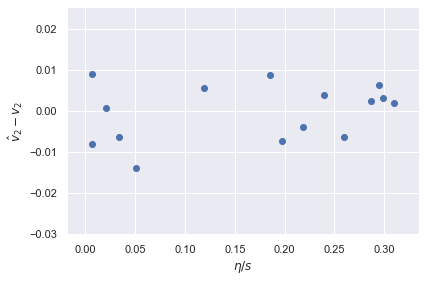

In [11]:
model_y_test = model_y_test.reshape(n_test_pts)
res = gp_y_test - model_y_test # calculate the residuals 
plt.scatter(model_X_test, res)
plt.xlabel(r'$\eta/s$')
plt.ylabel(r'$\hat{v}_2 - v_2$')
plt.tight_layout(True)
plt.show()

### Does the prediction look biased?

By inspection, it doesn't look like our emulator has signficant bias for any value of $\eta/s$. 
They are even more illuminating tests one can make, for example Quantile-Quantile plots (https://en.wikipedia.org/wiki/Q–Q_plot). You can explore this on your own.

# Performing Bayesian Inference
Now, we have a fast and accurate surrogate that we can trust to compare to data anywhere in the parameter space 

So we want to use our emulator to perform **Bayesian inference**.

Recall, that our **posterior** $p(\theta|D)$ of our parameters $\theta$ given the observed experimental data $D$ is the product of our **prior** belief about the parameters $p(\theta)$ and the **likelihood** $p(D|\theta)$ of observing those experimental data given the true value of the parameters is $\theta$. This is Bayes Theorem:

$$p(\theta|D) \propto p(D|\theta)p(\theta).$$

So, before using experimental data to update our belief about $\eta/s$, we need to define our prior belief about $\eta/s$.

### Choosing our Priors

We will define two different priors, so we can examine the effect that our prior has on our posterior.

One prior will be flat between two limits. The other prior will be informed by a belief, before seeing our $v_2$ data, that the shear viscosity is more likely to be a certain value within these limits.

In [12]:
#define two different priors, one more informed than the other
theta_min = eta_over_s_min
theta_max = eta_over_s_max

#a flat prior
def log_flat_prior(theta):
    """Flat prior on value between limits"""
    if (theta_min < theta) and (theta < theta_max):
        return 0. # log(1)
    else:
        return -np.inf  # log(0)
log_flat_prior = np.vectorize(log_flat_prior)
    
#a peaked prior
prior_peak = 2. / (4. * np.pi)  # the value of theta we belief most likely, before seeing data
prior_width = 1. / (10. * np.pi) #our uncertainty about this value, before seeing the data
def log_peaked_prior(theta):
    """Peaked (Gaussian) prior on value between limits"""
    if (theta_min < theta) and (theta < theta_max):
        return -0.5 * (theta - prior_peak)**2. / prior_width**2. 
    else:
        return -np.inf  # log(0)
log_peaked_prior = np.vectorize(log_peaked_prior)

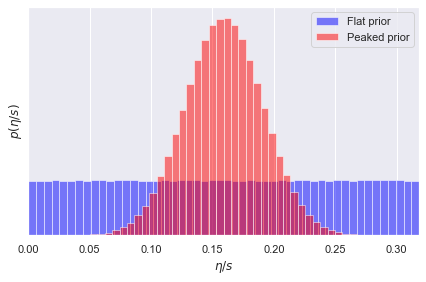

In [13]:
#lets plot our two priors by sampling them, and plotting their histograms
n_samples_prior = int(1e6)
samples_flat_prior = np.random.uniform(theta_min, theta_max, n_samples_prior) 
samples_peaked_prior =  np.random.normal( prior_peak, prior_width, n_samples_prior) 
plt.hist(samples_flat_prior, label='Flat prior', alpha=0.5, density=True, color='blue', bins=50)
plt.hist(samples_peaked_prior, label='Peaked prior', alpha=0.5, density=True, color='red', bins=50)
plt.xlim([theta_min, theta_max])
plt.xlabel(r'$\eta/s$')
plt.ylabel(r'$p(\eta/s)$')
plt.yticks([])
plt.legend()
plt.tight_layout(True)
plt.show()

### Defining our Likelihood
To compare our model predictions with experiment, we need to define our likelihood function.
The likelihood is a model for the conditional probability of observing the data given some true value of the parameters. Specifically,
the probability of observing some experimental value for $v_2$ given some value of $\eta/s$.

A commonplace assumption is to assume that the experimental errors follow a multivariate Gaussian distribution. This assumption is also the distribution which maximizes the information entropy subject to the constraints being normalizable, having a known mean, and a known variance...
This can be derived using the method of Lagrange multipliers. For details see (https://github.com/furnstahl/Physics-8805/blob/master/topics/maximum-entropy/MaxEnt.ipynb). 

In [14]:
def log_likelihood(theta, y_exp, dy_exp):
    #use our GP emulator to approximate the hydro model
    y_pred, dy_pred = emu_predict(theta) # emulation prediction and uncertainty
    dy_tot = np.sqrt( dy_pred**2. + dy_exp**2. ) #total uncertainty, emulation and exp.
    return -0.5 * np.sum( (y_pred - y_exp)**2 / dy_tot**2 )

### Exercises:
1. Why does the total uncertainty `dy_tot` in the likelihood function have this expression? What should be the total uncertainty, when we have experimental uncertainty and interpolation uncertainties which are independent?
2. How would this expression generalize to a vector of outputs, rather than a scalar output?

### Defining our Posterior 
The posterior is the product of the prior and likelihood function. 

It follows that the logarithm of the posterior is the sum of the logs of the prior and likelihood.

In [15]:
#posterior using flat prior
def log_posterior_flat_prior(theta, y_exp, dy_exp):
    '''Log posterior for data X given parameter array theta'''
    return log_flat_prior(theta) + log_likelihood(theta, y_exp, dy_exp)

#posterior using peaked prior
def log_posterior_peaked_prior(theta, y_exp, dy_exp):
    '''Log posterior for data X given parameter array theta'''
    return log_peaked_prior(theta) + log_likelihood(theta, y_exp, dy_exp)

### Inferring the value of $\eta/s$ using experimental data

Suppose that an experiment measures $v_2[20-30\%]$, and is reported by a mean value and total uncertainty...

In [16]:
exp_rel_uncertainty = 0.1 # experimental relative uncertainty
y_exp = 0.09 #v_2 experimental mean
dy_exp = y_exp * exp_rel_uncertainty #v_2 experimental uncertainty

Although our current problem is much-simplified by the use of a linear model, in general we will have no analytic expression for our likelihood function. In this case, one needs a set of numerical tools which can approximate the likelihood function. 

In addition, for many problems of interest our parameter space can be highly dimensional, so these methods need to work well for high-dimensional problems.

We solve both of these problems by employing Markov Chain Monte Carlo sampling (http://www.columbia.edu/~mh2078/MachineLearningORFE/MCMC_Bayes.pdf).

Specifically, we will use a python implementation called *Emcee* (https://emcee.readthedocs.io/en/stable/), which will work well for our purposes.

In [17]:
#this are some general settings for the MCMC
ndim = 1  # number of parameters in the model
nwalkers = 20*ndim  # number of MCMC walkers
nburn = 1000  # "burn-in" period to let chains stabilize
nsteps = 2000  # number of MCMC steps to take after the burn-in period finished

# we'll start at random locations within the prior volume
starting_guesses = theta_min + \
                   (theta_max - theta_min) * np.random.rand(nwalkers,ndim)

####Sampling the posterior with a flat prior####
print("Sampling Posterior with Flat Prior...")
print("MCMC sampling using emcee (affine-invariant ensamble sampler) with {0} walkers".format(nwalkers))
sampler_flat_prior = emcee.EnsembleSampler(nwalkers, ndim, log_posterior_flat_prior, args=[y_exp, dy_exp])
# "burn-in" period; save final positions and then reset
pos, prob, state = sampler_flat_prior.run_mcmc(starting_guesses, nburn)
sampler_flat_prior.reset()
# production sampling period
sampler_flat_prior.run_mcmc(pos, nsteps)
print("Mean acceptance fraction: {0:.3f} (in total {1} steps)"
                .format(np.mean(sampler_flat_prior.acceptance_fraction),nwalkers*nsteps))
# discard burn-in points and flatten the walkers; the shape of samples is (nwalkers*nsteps, ndim)
samples_flat_prior = sampler_flat_prior.chain.reshape((-1, ndim))

####Sampling the posterior with a peaked prior####
print("Sampling Posterior with Peaked Prior...")
print("MCMC sampling using emcee (affine-invariant ensamble sampler) with {0} walkers".format(nwalkers))
sampler_peaked_prior = emcee.EnsembleSampler(nwalkers, ndim, log_posterior_peaked_prior, args=[y_exp, dy_exp])
# "burn-in" period; save final positions and then reset
pos, prob, state = sampler_peaked_prior.run_mcmc(starting_guesses, nburn)
sampler_peaked_prior.reset()
# production sampling period
sampler_peaked_prior.run_mcmc(pos, nsteps)
print("Mean acceptance fraction: {0:.3f} (in total {1} steps)"
                .format(np.mean(sampler_peaked_prior.acceptance_fraction),nwalkers*nsteps))
# discard burn-in points and flatten the walkers; the shape of samples is (nwalkers*nsteps, ndim)
samples_peaked_prior = sampler_peaked_prior.chain.reshape((-1, ndim))

Sampling Posterior with Flat Prior...
MCMC sampling using emcee (affine-invariant ensamble sampler) with 20 walkers
Mean acceptance fraction: 0.809 (in total 40000 steps)
Sampling Posterior with Peaked Prior...
MCMC sampling using emcee (affine-invariant ensamble sampler) with 20 walkers
Mean acceptance fraction: 0.804 (in total 40000 steps)


### Plotting our Posteriors

We can plot the samples of our posterior as histograms.

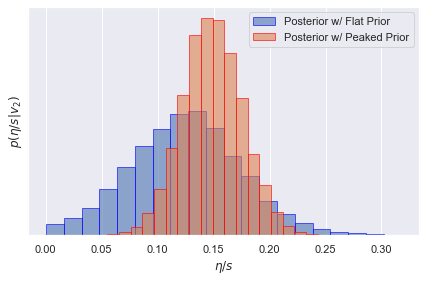

In [18]:
plt.hist(samples_flat_prior, bins=20, density=True, alpha=0.6, 
         edgecolor='blue', label='Posterior w/ Flat Prior')
plt.hist(samples_peaked_prior, bins=20, density=True, alpha=0.6, 
         edgecolor='red', label='Posterior w/ Peaked Prior')
plt.xlabel(r'$\eta/s$')
plt.ylabel(r'$p(\eta/s | v_2)$')
plt.yticks([])
plt.legend()
plt.tight_layout(True)
plt.show()

### Exercises

1. What do you notice is different about the two posteriors above, their median, their uncertainties, etc?
2. Try reducing the experimental error on our measurement. What do you expect to happen, and what happens? How does it depend on our emulation (interpolation) uncertainty?
3. Try playing with the parameters which defined the 'peaked' prior (e.g. reducing/increasing it's width). What happens?
4. In the case where we use the flat prior, what is the relation between the posterior and the likelihood function?

### Their are many useful libraries for plotting posteriors...
The corner library provides an easy to use implementation. This is especially helpful for doing
parameter estimation in more than one dimension.

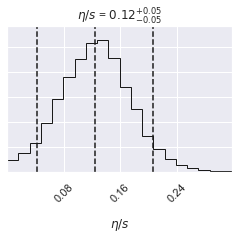

In [19]:
# make a corner plot with the posterior distribution
fig = corner.corner(samples_flat_prior, labels=["$\eta/s$"],
                    quantiles=[0.05, 0.5, 0.95], #what do these limits control?
                    show_titles=True, title_kwargs={"fontsize": 12})
plt.tight_layout(True)
plt.show()

# We're finished!

Now you can try applying some of these ideas to your own research. 